In [1]:
%pylab
%matplotlib inline

from scipy.integrate import quad

Using matplotlib backend: MacOSX
Populating the interactive namespace from numpy and matplotlib


In [7]:
def integrand1(x, s, a=7.96809574e-06, b=1.19521436e-05, p=0.00019306977288832455):
    return x ** (s - 1) * np.exp(-0.5 * x ** 2 / a - 0.5 * p ** 2 * x ** (-2) / b)

def integrand_original(x, mean, variance, p):
    return np.exp(-0.5 * ( (x-mean[0]) ** 2 / variance[0] + (p / x - mean[1]) ** 2 / variance[1]) ) / x

In [5]:
m = 0
n = 15
s = 2 * m - n

x = linspace(0.008, 0.03, 500)
y = [integrand(_, s = s) for _ in x]

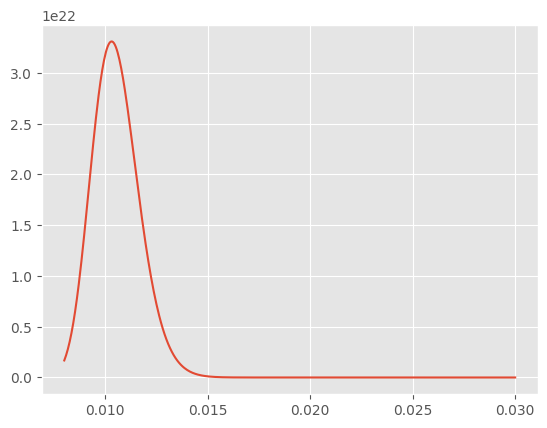

In [6]:
plot(x, y)
# vlines(0.010310017671626957, 0, 4e22, colors = 'k')

In [10]:
tmp = quad(
    integrand1,
    0,
    1,
    args=(s, ),
    limit=1000,
    epsabs=1e-30,
    epsrel=1e-10
)

In [217]:
mean = (0.8, 2.2)
variance = (1, 2)
p = 0.00019306977288832455

res = quad(
    integrand_original,
    0,
    1,
    args=(mean, variance, p),
    limit=1000,
    epsabs=1e-30,
    epsrel=1e-10,
    full_output=1
)

In [13]:
res[0], res[1]

(4.5700482621885665e-21, 2.7714768093970395e-32)

In [240]:
def func(mean, variance, p):
    if p <= 2:
         res = quad(
            integrand_original,
            1,
            p,
            args=(mean, variance, p),
            limit=1000,
            epsabs=1e-30,
            epsrel=1e-10
        )[0]
    if p > 2:
        res = quad(
            integrand_original,
            p / 2,
            2,
            args=(mean, variance, p),
            limit=1000,
            epsabs=1e-30,
            epsrel=1e-10
        )[0]
    D1 = norm.cdf(2, mean[0], variance[0] ** 0.5) - norm.cdf(1, mean[0], variance[0] ** 0.5)
    D2 = norm.cdf(2, mean[1], variance[1] ** 0.5) - norm.cdf(1, mean[1], variance[1] ** 0.5)
    return res / (2 * np.pi * np.sqrt(variance[0] * variance[1]) * D1 * D2)

def func_Taylor(mean, variance, p, nTaylor=10):
    faInCell = np.zeros((nTaylor, nTaylor + 1))
    for n in range(nTaylor):
        for m in range(n + 1):
            tmp = quad(
                integrand1,
                0,
                1.0,
                args=(2 * m - n, variance[0], variance[1], p),
                limit=1000,
                epsabs=1e-30,
                epsrel=1e-10
            )

            faInCell[n, m] = (
                p ** (n - m)
                / math.factorial(n)
                * (math.factorial(n) / math.factorial(m) / math.factorial(n - m))
                * (mean[0] / variance[0]) ** m
                * (mean[1] / variance[1]) ** (n - m)
                * tmp[0]
            )
    return np.sum(faInCell) * np.exp(-0.5 * (mean[0] ** 2 / variance[0] ** 2 + mean[1] ** 2 / variance[1] ** 2))

In [218]:
from scipy.stats import norm

def rcond_norm(N, loc, scale):
    alpha = norm.cdf(1, loc, scale)
    beta = norm.cdf(2, loc, scale)
    Z = beta - alpha 
    return norm.ppf(np.random.rand(int(N)) * Z + alpha, loc, scale)

assert np.all(rcond_norm(1000, -0.5, 10) >= 1) and  np.all(rcond_norm(1000, 20, 10) <= 2)
rcond_norm(10, mean[0], variance[0])

array([1.36203958, 1.75537009, 1.46699677, 1.01632586, 1.05685346,
       1.07477347, 1.21691688, 1.47051798, 1.09280346, 1.4257888 ])

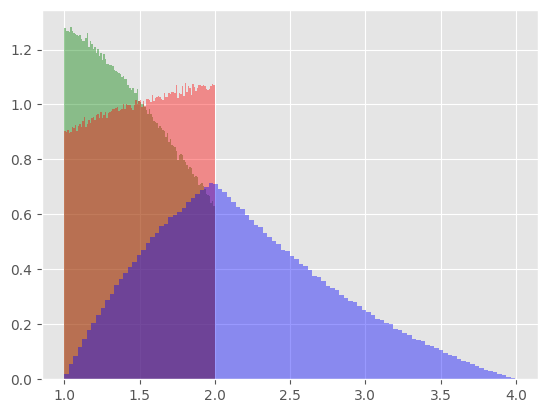

In [237]:
def sample(mean, variance, N=1e3):
    return rcond_norm(N, mean[0], variance[0] ** 0.5) * rcond_norm(N, mean[1], variance[1] ** 0.5)

s = sample(mean, variance, int(1e6))
density = gaussian_kde(s)

from scipy.stats import gaussian_kde
x = rcond_norm(1e6, mean[0], variance[0])
y = rcond_norm(1e6, mean[1], variance[1])

n, bins, patches = plt.hist(x, 100, density=True, facecolor='g', alpha=0.4)
n, bins, patches = plt.hist(y, 100, density=True, facecolor='r', alpha=0.4)
n, bins, patches = plt.hist(x * y, 100, density=True, facecolor='b', alpha=0.4)

In [238]:
# pvals = 10 ** np.linspace(-5, 0, 50)
pvals = np.linspace(1, 4, 200)
potentials = list(map(lambda p: func(mean, variance, p), pvals))
# potentials_Taylor = list(
#     map(
#         lambda p: func_Taylor(mean, variance, p),
#         pvals
#     )
# )

<ipython-input-235-b0ee3e8d8241>:3: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  res = quad(
<ipython-input-235-b0ee3e8d8241>:13: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  res = quad(


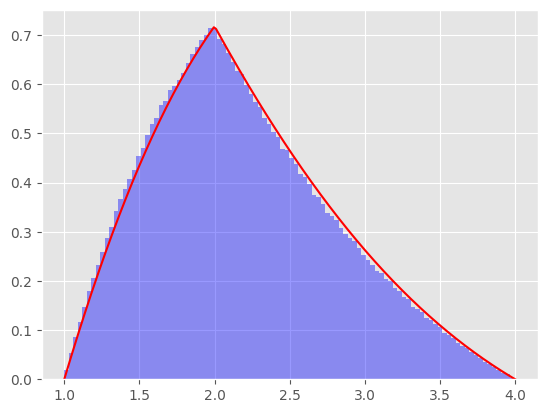

In [241]:
plt.plot(pvals, potentials, 'r-')
n, bins, patches = plt.hist(x * y, 100, density=True, facecolor='b', alpha=0.4)
# plt.plot(pvals, density(pvals), 'k--')
# plt.semilogx(pvals, potentials_Taylor, 'k--')

In [70]:
from sympy.solvers import solve
from sympy.abc import x, p, s, a, b

expr = (s - 1) + (p ** 2 / b * x ** (-2) - x ** 2/ a)
res = solve((s - 1) + (p ** 2 / b * x ** (-2) - x ** 2/ a), x)

In [71]:
expr = res[3]
expr

sqrt(2)*sqrt(a*s - a + sqrt(a**2*b**2*s**2 - 2*a**2*b**2*s + a**2*b**2 + 4*a*b*p**2)/b)/2

In [72]:
out = [_.subs([[a, 7.96809574e-06], [b, 1.19521436e-05], [s, -15], [p, 0.00019306977288832455]]) for _ in res]
out

[-0.0108117065311*sqrt(2)*I,
 0.0108117065311*sqrt(2)*I,
 -0.00729028340976056*sqrt(2),
 0.00729028340976056*sqrt(2)]

In [73]:
float(out[-1])

0.010310017671626957

In [74]:
integrand1(float(out[-1]), -15)

3.310491898317922e+22